# Created by Rogério Xavier de Azambuja
# https://sites.google.com/farroupilha.ifrs.edu.br/xwines
# rogerio.xavier@farroupilha.ifrs.edu.br

In [1]:
# Opening required packages for processing
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1-"  # "-1" for none
#os.environ.pop('TF_CONFIG', None)
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import pandas as pd
pd.set_option('max_colwidth', None)

import numpy as np
np.random.seed(76)

import tensorflow as tf
tf.random.set_seed(76)
tf.keras.utils.set_random_seed(76)  ### set seed

import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Opening required packages to show output
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# X-Wines Data Preprocessing steps --------------------

# On-line Data

In [3]:
trainDF0 = pd.read_csv("Data/trainDF00001_site.csv", low_memory=False, encoding="utf-8", memory_map=True)
testDF0 = pd.read_csv("Data/testDF00001_site.csv", low_memory=False, encoding="utf-8", memory_map=True)
datasetName = 'X-Wines_Users'
trainDF = trainDF0.copy().sort_values(by='Date')
testDF = trainDF0[trainDF0.UserID<1000].sort_values(by='Date')
len(trainDF0), len(testDF0)

(339448, 152)

In [4]:
trainDF0.UserID.unique().size

102182

In [5]:
trainDF0.ItemID.unique().size

15699

In [6]:
testDF0.UserID.unique().size

152

# Off-line Data

In [7]:
# opening selected pandas dataframe
datasetName = 'X-Wines_Slim'
#datasetName = 'MovieLens_1M'

if datasetName == 'X-Wines_Slim':
    trainDF0 = pd.read_csv("Data/slimTrainDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    testDF0  = pd.read_csv("Data/slimTestDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    
    trainDF = trainDF0.copy()
    testDF  = pd.read_csv("Data/slimTestSeqDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    print(trainDF0.shape, testDF0.shape, 'with last sequence:', trainDF.shape, testDF.shape)
elif datasetName == 'MovieLens_1M':
    trainDF0 = pd.read_csv("Data/movieTrainDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    testDF0  = pd.read_csv("Data/movieTestDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    
    trainDF = trainDF0.copy()
    testDF  = pd.read_csv("Data/movieTestSeqDF.csv", low_memory=False, encoding="utf-8", memory_map=True)
    print(trainDF0.shape, testDF0.shape, 'with last sequence:', trainDF.shape, testDF.shape)    
else:
    print('Dataset inconsistency!!!')

(124909, 7) (8369, 7) with last sequence: (124909, 7) (83690, 7)


In [8]:
trainDF0.UserID.unique().size

8369

In [9]:
trainDF0.ItemID.unique().size

894

In [10]:
testDF0.UserID.unique().size

8369

# X-Model and Classical Collaborative Models

In [11]:
from sklearn.metrics import ndcg_score

#useful dataframe functions
def getInteractedItemsByUser(userID, df, threshold=0):
    return df.loc[(df.UserID==userID) & (df.Rating>=threshold)]['ItemID'].unique()

def getNonInteractedItemsByUser(userID, df, threshold=0):
    interactedItems = getInteractedItemsByUser(userID, df, threshold=threshold) 
    nonInteractedItems = (set(df.ItemID.unique()) - set(interactedItems))  # all items (-) iteracted items
    return list(nonInteractedItems)

def combineFeatures(row={}, features=[]):
    combinedFeatures = ''.join(str(row[feature])+' ' for feature in features)  
    return combinedFeatures.strip().lower()

def ajust5StarsRating(rating): # 5-star ratings {0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}
    if rating < 0.5:
        return 0.5
    elif rating > 5:
        return 5.0
    else:
        decimal = round(rating - int(rating), 1)
        if decimal >= 0.8:
            rating = int(rating) + 1.0
        elif decimal >= 0.3:
            rating = int(rating) + 0.5
        else:
            rating = int(rating)
        return round(float(rating),1)

# common model
class Model:
    _ModelName = 'Model'
    _recommendation = pd.NA  # _recommendation['UserID', 'Items', 'Weights', 'NextItem'] dtype [int, str(list), str(list), int]

    def __call__(self, testDF, addName='')->bool:
        try:
            # create the output recommendation space 
            self._recommendation = pd.DataFrame(testDF.UserID.unique(), columns=['UserID'])    
            # add NextItem for evaluate
            self._recommendation = pd.merge(self._recommendation, testDF[['UserID', 'ItemID']], on=['UserID'], how='left')\
                                        .rename(columns={'ItemID': 'NextItem'})
            # fields Items and Weights to be filled by method recommender()
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA  
            self._ModelName += addName
            print(self._ModelName, 'was created for', len(self._recommendation), 'user next item')
            return True
        except:
            print(self._ModelName + addName, 'was not created')
        return False
    
    def getName(self)->str:
        return self._ModelName
    
    def getRecommendations(self)->pd.DataFrame:
        return self._recommendation
    
    def getRecommendationByUser(self, userID=0, topN=10)->set:
        try:
            if (topN not in range(1, 51) or int(userID)<=0):
                print(self._ModelName, 'need top-N between 1-training:50 and a valid user ID')
                return {'nop': -1}
            listItems = eval(self._recommendation.loc[self._recommendation.UserID==userID]['Items'].values[0])[:topN]              
            return {"Name": self._ModelName, "UserID": userID, "Top-"+str(topN): listItems}
        except:
            print('Dataset inconsistency, need to run recommender method first.')
        return {'nop': -1}
    
    # Evaluation: 1 and position>=0 if matched between set of items recomendation and set of itemsID test(here = |1|) or
    #             0 and position=-1 if not matched, for that user.
    def _hitTopN(self, nextItemID, recommendation, topN=10)->tuple:
        for item in list(enumerate(recommendation))[:topN]: # (0, itemID0) (1, itemID1)... topN
            if item[1]==nextItemID:
                return 1, item[0]
        return 0, -100

    # processing global average for Precision@topN, Recall@topN, F1-Score@topN
    def _evaluateTopN(self, topN=10)->tuple:
        hitSumP, hitSumR, hitSumRR, hitSumAP, f1Score, hitSumnDCG = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        totalUsers = float(len(self._recommendation))
        #relevance = np.asarray([np.arange(1, topN+1)[::-1]])  # inverse positions relevance
        for index, row in  self._recommendation.iterrows():   # for each user do
            hit, position = self._hitTopN(row.NextItem, eval(row.Items), topN)
            # Precision
            hitSumP += hit * (1/topN)
            # Recall
            hitSumR += hit  #hitSum += hit*(1/len(user Test set)) here = |1|
            # MAP
            hitSumAP += hit * (1/(position + 1)) # here = |1|  ????  MAP=MRR where |1|
            # MRR
            hitSumRR += hit * (1/(position + 1)) # here = |1|
            # nDGC      
            if hit==1:
                if topN==1:
                    hitSumnDCG += 1
                else:
                    scores = np.repeat(0, topN)
                    scores[position] = 1 
                    relevance = np.asarray([sorted(scores, reverse=True)])
                    scores = np.asarray([scores])
                    hitSumnDCG += ndcg_score(relevance, scores, k=topN)
            
        precision = float(hitSumP/totalUsers)
        recall    = float(hitSumR/totalUsers)
        MAP       = float(hitSumAP/totalUsers)  
        MRR       = float(hitSumRR/totalUsers)
        nDCG      = float(hitSumnDCG/totalUsers)
        if (precision + recall) > 0:  # avoid division by zero
            f1Score = float(2 * (precision * recall)/(precision + recall))
        return round(precision, 6), round(recall, 6), round(f1Score, 6), round(MAP, 6), round(MRR, 6), round(nDCG, 6)
    
    def evaluate(self, topN=10)->set:
        try:
            if (topN not in range(1, 51)):
                print(self._ModelName, 'need run recommender method and top-N between 1-training:50')
                return {'nop': -1}
            print('processing evaluate', "Top-"+str(topN), '...', end='')
            precision, recall, f1Score, MAP, MRR, nDCG = self._evaluateTopN(topN)
            result = {"Name":self._ModelName, "P@"+str(topN):precision, "R@"+str(topN):recall, "F1@"+str(topN):f1Score, \
                      "MAP@"+str(topN):MAP, "MRR@"+str(topN):MRR, "NDCG@"+str(topN):nDCG}
            print(result)
            return result
        except:
            print('Evaluator inconsistency, need to run recommender method first.')
        return {'nop': -1}
    
    #Method to be rewritten by inheritance to fill _recommendation
    def recommender(self, topN=10)->bool:
        print('This recommender needs to be redefined with the heuristic to generate recommendation.')
        return False   

In [12]:
# NearestNeighbors

In [13]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

class NearestNeighborsModel(Model):
    _ModelName = 'NearestNeighbors'
    
    def __init__(self, xDF, yDF, addName=''):
        try:
            if (not set(['UserID', 'ItemID', 'Rating']).issubset(xDF.columns) or not set(['UserID','ItemID']).issubset(yDF.columns)):
                print("dataset inconsistency, need columns as ['UserID', 'ItemID', 'Rating']")
                return None
            self._train = xDF[['UserID', 'ItemID', 'Rating']]
            self._recommendation, self._matrixFactorization, self._model, self._indexItemID = pd.NA, pd.NA, pd.NA, pd.NA
            self.__call__(yDF, addName)
            return
        except:
            print('dataset inconsistency')
            return None          
    
    def getMatrixFactorization(self)->pd.DataFrame:
        return self._matrixFactorization
    
    def _itemMoreSimilarFromItemID(self, itemID, topN=50)-> (list, list):
        index = self._indexItemID[self._indexItemID.values==itemID].index[0]
        distances, suggestions = self._model.kneighbors( self._matrixFactorization.iloc[index, :].values.reshape(1, -1))
        return self._matrixFactorization.index[suggestions[0].tolist()[1:topN+1]], distances[0].tolist()[1:topN+1]
    
    def _computeNearestNeighbors(self, n_neighbors=50):
        self._train = self._train.drop_duplicates(['UserID', 'ItemID'], keep='last')
        # pivoting treatment        
        self._matrixFactorization = self._train.pivot(columns='UserID', index='ItemID', values='Rating').fillna(0)
        # sparsivity treatment
        pivotSparse = csr_matrix(self._matrixFactorization.values)
        self._model = NearestNeighbors(algorithm='auto', metric='cosine', n_neighbors=n_neighbors)
        self._model.fit(pivotSparse)
        self._indexItemID = self._matrixFactorization.reset_index()['ItemID']
        return
    
    def recommender(self, topN=50, plus='Short')->bool:
        try:
            if (topN not in range(1, 51)):
                self._recommendation, self._matrixFactorization, self._model, self._indexItemID = pd.NA, pd.NA, pd.NA, pd.NA
                print(self._ModelName, 'need top-N in 0-50')
                return False
            self._ModelName = self._ModelName+"-"+plus if len(plus)>0 else self._ModelName
            print(self._ModelName, 'processing recommender...')
            self._computeNearestNeighbors(topN) # -> _itemMoreSimilarFromItemID(itemID)

            # produces a set of recommendations for each tested user
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA
            for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]):
                interactedItemsByUser = getInteractedItemsByUser(row.UserID, self._train, threshold=0) # (-) iteracted items
                similarItemsIDs, similarItemsVal = [], []
                if plus=='Long':
                    for interactedItem in list(interactedItemsByUser)[-10:]:  # sequential recommender
                        similarItemsIDsByUser, similarItemsValByUser = self._itemMoreSimilarFromItemID(interactedItem, 10) 
                        similarItemsIDs += list(similarItemsIDsByUser)
                        similarItemsVal += list(similarItemsValByUser)
                else:                       
                    lastItemID = list(interactedItemsByUser)[-2:-1]
                    similarItemsIDs, similarItemsVal = self._itemMoreSimilarFromItemID(lastItemID, topN)  

                predictionsItemsByUser = pd.DataFrame({'ItemID': similarItemsIDs, 'Distance': similarItemsVal}) \
                                .sort_values(by='Distance', ascending=True).drop_duplicates(subset=['ItemID'], keep='first')
                predictionsItemsByUser = predictionsItemsByUser.reset_index(drop=True).head(topN)
                self._recommendation.at[index, 'Items']   = str(list(predictionsItemsByUser.ItemID))
                self._recommendation.at[index, 'Weights'] = str([1.0-x for x in list(predictionsItemsByUser.Distance)])
            return True
        except ValueError:
            self._recommendation, self._matrixFactorization, self._model, self._indexItemID = pd.NA, pd.NA, pd.NA, pd.NA
            print('recommender inconsistency', ValueError)
        return False

In [14]:
# Collaborative-Filtering

In [15]:
from scipy.sparse import csr_matrix 
from scipy.sparse.linalg import svds
from surprise import *

class CollaborativeFilteringModel(Model):
    _ModelName = 'Collaborative Filtering'
    
    def __init__(self, xDF, yDF, addName=''):
        try:
            if (not set(['UserID', 'ItemID', 'Rating']).issubset(xDF.columns) or not set(['UserID','ItemID']).issubset(yDF.columns)):
                print("dataset inconsistency, need columns as ['UserID', 'ItemID', 'Rating']")
                return None
            self._train = xDF
            self._recommendation, self._matrixFactorization = pd.NA, pd.NA
            self.__call__(yDF, addName)
            return 
        except:
            print('dataset inconsistency')
        return None           
    
    def getMatrixFactorization(self)->pd.DataFrame:
        return self._matrixFactorization
    
    def _computeMatrixFactorizationSVD(self, predict=False, nFactors=20):
        self._train = self._train.drop_duplicates(['UserID', 'ItemID'], keep='last')
        # pivoting treatment        
        self._matrixFactorization = self._train.pivot(index='UserID', columns='ItemID', values='Rating').fillna(0)
        matrixColumns = self._matrixFactorization.columns
        matrixIndexes = self._matrixFactorization.index      
        if predict==True:   
            reader = Reader(rating_scale=(self._train.Rating.min(), self._train.Rating.max()))
            data = Dataset.load_from_df(self._train[['UserID', 'ItemID', 'Rating']], reader)
            algo =  SVDpp(lr_all=0.5) # [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]):
            algo.fit(data.build_full_trainset())
            for col in tqdm(matrixColumns):
                self._matrixFactorization[col] = [ algo.predict(uid=index, iid=col).est if (value==0) else value \
                                                  for index, value in zip(matrixIndexes, self._matrixFactorization[col])]
            self._matrixFactorization = self._matrixFactorization.transpose()
        else:
            # sparsivity treatment
            self._matrixFactorization = csr_matrix(self._matrixFactorization.values)
            # factorization of the original user-item matrix by partial singular value decomposition (SVD)
            u, s, vh = svds(self._matrixFactorization, k=nFactors) # MxN, where u=unitary matrix(M, k), s=singular value, vh=unitary matrix (k, N)
            s = np.diag(s) # extract a diagonal (k, k)
            # matrix reconstruction based on dot product of two arrays to approximate ratings
            self._matrixFactorization = np.dot(np.dot(u, s), vh)  #np.round(u.dot(np.diag(s).dot(vt)))
            # to dataframe
            self._matrixFactorization = pd.DataFrame(self._matrixFactorization, columns=matrixColumns, index=matrixIndexes).transpose()
        
        # normalization (0-1)
        self._matrixFactorization = ( self._matrixFactorization - self._matrixFactorization.min() ) /  \
                                    ( self._matrixFactorization.max() - self._matrixFactorization.min() )    
        return
    
    def recommender(self, topN=50, predict=False, nFactors=20)->bool:
        try:
            if (topN not in range(1, 51)):
                self._recommendation, self._matrixFactorization = pd.NA, pd.NA
                print(self._ModelName, 'need top-N in 0-50')
                return False
            if predict:
                self._ModelName+="-SVDpp"

            print(self._ModelName, 'processing recommender...')

            self._computeMatrixFactorizationSVD(predict, nFactors)
            
            # produces a set of recommendations for each tested user
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA
            for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]):
                predictionsItemsByUser = self._matrixFactorization[row.UserID].sort_values(ascending = False) \
                                                .reset_index().rename(columns={row.UserID: 'Weight'})
                # Removing items already seen
                interactedItemsByUser = getInteractedItemsByUser(row.UserID, self._train, threshold=0) 
                predictionsItemsByUser.loc[predictionsItemsByUser.ItemID.apply(lambda x: x not in interactedItemsByUser)] # (-) iteracted items
                predictionsItemsByUser = predictionsItemsByUser.sort_values('Weight', ascending = False).head(topN)               
                self._recommendation.loc[index, 'Items'] = str(list(predictionsItemsByUser.ItemID))
                self._recommendation.loc[index, 'Weights'] = str(list(predictionsItemsByUser.Weight))
            return True
        except ValueError:
            self._recommendation, self._matrixFactorization = pd.NA, pd.NA
            print('dataset inconsistency', ValueError)
        return False

In [16]:
# Content-based filtering

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, haversine_distances, manhattan_distances 
# greater similarity is achieved with less distance ex. cosine_similarity = 1 - cosine_distances(A, B)

from sklearn.feature_extraction.text import TfidfVectorizer

class ContentFilteringModel(Model):
    _ModelName = 'Content-based Filtering'
    
    def __init__(self, xDF, yDF, itemsDF, featuresDF=['ItemID'], addName=''):
        try:
            if (not set(['UserID', 'ItemID', 'Rating']).issubset(xDF.columns) or not set(['UserID', 'ItemID']).issubset(yDF.columns) \
               #or not set(['ItemID', 'Type', 'Body', 'Acidity']).issubset(itemsDF.columns)):
                or not set(['ItemID']).issubset(itemsDF.columns)):
                print("dataset inconsistency, need columns as ['UserID', 'ItemID', 'Rating'] and item features")
                return None
            self._train, self._itemsDF, self._features = xDF, itemsDF, featuresDF
            self._matrixSimilarity = pd.NA
            self.__call__(yDF, addName)
            return 
        except ValueError:
            print('dataset inconsistency', ValueError)
        return None           
    
    def getMatrixSimilarity(self)->pd.DataFrame:
        return self._matrixSimilarity
    
    def _computeMatrixSimilarity(self, distance='cosine'):
        self._itemsDF = self._itemsDF.fillna('').sort_values(by=['ItemID']).reset_index(drop=True)
        self._itemsDF["combinedFeatures"] = self._itemsDF.apply(lambda a: combineFeatures(a, self._features), axis=1)

        cv = CountVectorizer(stop_words='english', lowercase=True)   
        countVector = cv.fit_transform(self._itemsDF["combinedFeatures"])
        #tfidf = TfidfVectorizer(stop_words='english', lowercase=True)
        #countVector = tfidf.fit_transform(self._itemsDF["combinedFeatures"])
        
        if distance=='euclidian':
            matrixDistance = euclidean_distances(countVector)
        elif distance=='manhattan':
            matrixDistance = manhattan_distances(countVector)           
        elif distance=='haversine':
            matrixDistance = haversine_distances(countVector)
        else:
            matrixDistance = cosine_distances(countVector)
        # normalize (0-1) befor and greater similarity is achieved with less distance  
        self._matrixSimilarity = 1.0 - ((matrixDistance - matrixDistance.min())/(matrixDistance.max() - matrixDistance.min()))
        self._matrixSimilarity = pd.DataFrame(self._matrixSimilarity.astype(float), columns=self._itemsDF.ItemID, index=self._itemsDF.ItemID)
        return
        
    def recommender(self, distance='cosine', topN=50)->bool:
        try:
            if (topN not in range(1,51)):
                self._recommendation, self._matrixSimilarity = pd.NA, pd.NA
                print(self._ModelName, 'need top-N in 0-50')
                return False
            self._ModelName += '-' + distance
            print(self._ModelName, 'processing recommender...')
            # 1. used combined items features -> 2. vetorial space -> 3. similarity
            self._computeMatrixSimilarity(distance)
            
            # produces a set of recommendations for each tested user                    
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA
            for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]):
                interactedItemsByUser = getInteractedItemsByUser(row.UserID, self._train, threshold=3.5) # best items
                similarItemsIDs = []
                similarItemsVal = []
                for interactedItem in interactedItemsByUser:
                    similarItems = self._matrixSimilarity[interactedItem].sort_values(ascending = False) 
                    similarItems = similarItems.loc[similarItems.index!=interactedItem].head(30) # relation 1 to 30 (-) same item (diagonal position)
                    similarItemsIDs += list(similarItems.index) 
                    similarItemsVal += list(similarItems.values)
                similarItemsByUser = pd.DataFrame({'ItemID': similarItemsIDs, 'Similarity': similarItemsVal}) \
                                .sort_values(by='Similarity', ascending=False).drop_duplicates(subset=['ItemID'], keep='first')
                similarItemsByUser = similarItemsByUser.reset_index(drop=True).head(topN)
                self._recommendation.loc[index, 'Items'] = str(list(similarItemsByUser.ItemID))
                self._recommendation.loc[index, 'Weights'] = str(list(similarItemsByUser.Similarity))
            return True
        except ValueError:
            self._recommendation, self._matrixSimilarity = pd.NA, pd.NA
            print('dataset inconsistency', ValueError)
        return False

In [18]:
# Hybrid Filtering

In [19]:
class HybridFilteringModel(Model):
    
    _ModelName = 'Hybrid Filtering'
    
    def __init__(self, cfRecommender, cbRecommender, cfRatio=90, cbRatio=10, addName=''):
        try:
            if ( not set(['UserID', 'NextItem', 'Items', 'Weights']).issubset(cfRecommender.getRecommendations().columns) or 
                 not set(['UserID', 'NextItem', 'Items', 'Weights']).issubset(cbRecommender.getRecommendations().columns) ):
                print("dataset inconsistency, need columns as ['UserID','Items','Weights','NextItem'] and ratio (0-100%)")
                return None
            cfRec = cfRecommender.getRecommendations().rename(columns={'Items': 'ItemsCF', 'Weights': 'WeightsCF', 'NextItem': 'ItemID'})
            cbRec = cbRecommender.getRecommendations().rename(columns={'Items': 'ItemsCB', 'Weights': 'WeightsCB', 'NextItem': 'ItemID'})
            self._recommendationsFB = pd.merge(cfRec, cbRec, on=['UserID', 'ItemID'], how='inner')
            self._cfRatio = cfRatio
            self._cbRatio = cbRatio
            self.__call__(self._recommendationsFB[['UserID', 'ItemID']], addName)
            self._recommendationsFB = self._recommendationsFB.drop(columns=['ItemID'])
            return 
        except ValueError:
            print('dataset inconsistency', ValueError)
        return None           
        
    def recommender(self, topN=50)->bool:
        try:
            if (topN not in range(1,51)):
                self._recommendation = pd.NA
                print(self._ModelName, 'need top-N in 0-50')
                return False
            
            print(self._ModelName, 'processing recommender...')
            # produces a set of recommendations for each tested user   
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA
            for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]): 
                recByUser = self._recommendationsFB.loc[self._recommendationsFB.UserID==row.UserID][:1].reset_index(drop=True)
                                                 
                recCFByUser = pd.DataFrame({'ItemID': eval(recByUser.ItemsCF[0]), 'WeightCF': eval(recByUser.WeightsCF[0])})
                recCBByUser = pd.DataFrame({'ItemID': eval(recByUser.ItemsCB[0]), 'WeightCB': eval(recByUser.WeightsCB[0])})
                
                recByUser = pd.merge(recCFByUser, recCBByUser, how='outer', on=['ItemID']).fillna(0.0)
                recByUser['Weight'] = (recByUser.WeightCB * self._cbRatio) + (recByUser.WeightCF * self._cfRatio)
                recByUser = recByUser.sort_values(by=['Weight'], ascending=False).head(topN)

                self._recommendation.loc[index, 'Items'] = str(list(recByUser.ItemID))
                self._recommendation.loc[index, 'Weights'] = str(list(recByUser.Weight))
            return True
        except ValueError:
            self._recommendation = pd.NA
            print('dataset inconsistency', ValueError)
        return False

In [20]:
# Random and Pop

In [21]:
import random

class SimpleModel(Model):
    _ModelName = 'Simple'
    _SEED = 256
    
    def __init__(self, xDF, yDF, addName=''):
        try:
            if (not set(['UserID','ItemID']).issubset(xDF.columns) or not set(['UserID','ItemID']).issubset(yDF.columns)):
                print("dataset inconsistency, need columns ['UserID','ItemID']")
                return None
            self._train = xDF
            self._recommendation = pd.NA
            random.seed(self._SEED)
            self.__call__(yDF, addName)
            return
        except ValueError:
            print('dataset inconsistency', ValueError)
        return None
    
    def _getRandomItemsBetweenAllItems(self, size=50, seed=_SEED):
        return random.choices(self._train.ItemID.unique(), k=size)
    
    def _getNonInteractedRandomItemsByUser(self, userID, size=50, seed=_SEED):
        nonInteractedItems = getNonInteractedItemsByUser(userID, self._train, threshold=0) # (-) iteracted items)
        return random.choices(nonInteractedItems, k=size)
    
    def _getNonInteractedPopularityItemsByUser(self, userID, size=50):
        nonInteractedItems = getNonInteractedItemsByUser(userID, self._train, threshold=0) # (-) iteracted items)
        df = pd.merge(self._train[['ItemID', 'Rating']], pd.DataFrame(nonInteractedItems, columns=['ItemID']), how='inner', on=['ItemID'])
        popularityItems = df.groupby('ItemID')['Rating'].sum().sort_values(ascending=False).reset_index()
        return list(popularityItems.head(size)['ItemID'].values)    
    
    def recommender(self, topN=50, useData='random')->bool:  #useData: 'all', 'noninteract' or noninteract-pop for (-) items interacted by users
        try:
            if (topN not in range(1,51)):
                self._recommendation = pd.NA
                print(self._ModelName, 'need top-N in 0-50')
                return False
            self._ModelName += "-" + useData
            print(self._ModelName, 'processing recommender...')
            
            # produces a set of recommendations for each tested user
            self._recommendation['Items'] = pd.NA
            self._recommendation['Weights'] = pd.NA
            for index, row in tqdm(self._recommendation.iterrows(), total=self._recommendation.shape[0]):
                if useData=='noninteract':
                    self._recommendation.at[index, 'Items'] = str(self._getNonInteractedRandomItemsByUser(userID=row.UserID, size=topN))
                elif useData=='noninteract-pop':
                    self._recommendation.at[index, 'Items'] = str(self._getNonInteractedPopularityItemsByUser(userID=row.UserID, size=topN))                
                else: # all
                    self._recommendation.at[index, 'Items'] = str(self._getRandomItemsBetweenAllItems(size=topN))
            return True
        except ValueError:
            self._recommendation = pd.NA
            print('dataset inconsistency', ValueError)
        return False

# Test Area

In [22]:
%%time
m0 = SimpleModel(trainDF0, testDF0)
m0.recommender()

Simple was created for 8369 user next item
Simple-random processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 6.17 s
Wall time: 13.5 s


True

In [23]:
m0.getRecommendationByUser(userID=1000004, topN=10)

{'Name': 'Simple-random',
 'UserID': 1000004,
 'Top-10': [112923,
  101783,
  114932,
  100025,
  103423,
  155807,
  163101,
  181492,
  111471,
  180089]}

In [24]:
m0.evaluate(5)

processing evaluate Top-5 ...{'Name': 'Simple-random', 'P@5': 0.001195, 'R@5': 0.005974, 'F1@5': 0.001991, 'MAP@5': 0.002505, 'MRR@5': 0.002505, 'NDCG@5': 0.003401}


{'Name': 'Simple-random',
 'P@5': 0.001195,
 'R@5': 0.005974,
 'F1@5': 0.001991,
 'MAP@5': 0.002505,
 'MRR@5': 0.002505,
 'NDCG@5': 0.003401}

In [25]:
%%time
m1 = SimpleModel(trainDF0, testDF0)
m1.recommender(useData='noninteract')

Simple was created for 8369 user next item
Simple-noninteract processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 9.23 s
Wall time: 20.2 s


True

In [26]:
%%time
m2 = SimpleModel(trainDF0, testDF0)
m2.recommender(useData='noninteract-pop')

Simple was created for 8369 user next item
Simple-noninteract-pop processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 1min 16s
Wall time: 2min 31s


True

In [27]:
%%time
m3 = CollaborativeFilteringModel(trainDF0, testDF0)
m3.recommender()

Collaborative Filtering was created for 8369 user next item
Collaborative Filtering processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 19.4 s
Wall time: 45.5 s


True

In [28]:
%%time
m4 = CollaborativeFilteringModel(trainDF0, testDF0)
m4.recommender(predict=True)

Collaborative Filtering was created for 8369 user next item
Collaborative Filtering-SVDpp processing recommender...


  0%|          | 0/894 [00:00<?, ?it/s]

  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 1min 31s
Wall time: 3min 30s


True

In [29]:
# Read wines
itemsDF = pd.read_csv("Data/XWines_Full_100K_wines.csv", low_memory=False, encoding="utf-8", memory_map=True) #XWines_Full_100K_wines.csv
# ['WineID', 'WineName', 'Type', 'Elaborate', 'Code', 'Body', 'Acidity', 'ABV']
featuresDF = ['Type', 'Body', 'Code', 'Elaborate']

itemsDF = itemsDF[['WineID']+featuresDF].rename(columns={'WineID': 'ItemID'})
addItem = pd.DataFrame(list(trainDF0.ItemID.unique()), columns=['ItemID'])
itemsDF = pd.merge(itemsDF, addItem, on=['ItemID'], how='inner')
itemsDF

,ItemID,Type,Body,Code,Elaborate
0,100001,Sparkling,Medium-bodied,BR,Varietal/100%
1,100003,Red,Full-bodied,BR,Varietal/100%
2,100005,Red,Full-bodied,BR,Assemblage/Bordeaux Red Blend
3,100007,Sparkling,Medium-bodied,BR,Varietal/100%
4,100008,Red,Full-bodied,BR,Varietal/100%
...,...,...,...,...,...
889,196920,Rosé,Full-bodied,MD,Varietal/100%
890,196946,Red,Light-bodied,HU,Varietal/100%
891,197673,Red,Full-bodied,AT,Varietal/100%
892,197934,White,Medium-bodied,AT,Varietal/100%


In [30]:
%%time
m5 = ContentFilteringModel(trainDF0, testDF0, itemsDF, featuresDF)
m5.recommender()

Content-based Filtering was created for 8369 user next item
Content-based Filtering-cosine processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 22.7 s
Wall time: 46.5 s


True

In [31]:
%%time
m6 = ContentFilteringModel(trainDF0, testDF0, itemsDF, featuresDF)
m6.recommender(distance='euclidian')

Content-based Filtering was created for 8369 user next item
Content-based Filtering-euclidian processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 19.7 s
Wall time: 46.3 s


True

In [32]:
%%time
m7 = ContentFilteringModel(trainDF0, testDF0, itemsDF, featuresDF)
m7.recommender(distance='manhattan')

Content-based Filtering was created for 8369 user next item
Content-based Filtering-manhattan processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 20.5 s
Wall time: 46.3 s


True

In [33]:
%%time
m8 = ContentFilteringModel(trainDF0, testDF0, itemsDF, featuresDF)
m8.recommender(distance='haversine')

Content-based Filtering was created for 8369 user next item
Content-based Filtering-haversine processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 20.6 s
Wall time: 45.4 s


True

In [34]:
%%time
m9 = HybridFilteringModel(m3, m5, 90, 10)
m9.recommender()

Hybrid Filtering was created for 8369 user next item
Hybrid Filtering processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 15.3 s
Wall time: 34.2 s


True

In [35]:
%%time
m10 = NearestNeighborsModel(trainDF0, testDF0)
m10.recommender()

NearestNeighbors was created for 8369 user next item
NearestNeighbors-Short processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 10.8 s
Wall time: 27.2 s


True

In [36]:
%%time
m11 = NearestNeighborsModel(trainDF0, testDF0)
m11.recommender(plus='Long')

NearestNeighbors was created for 8369 user next item
NearestNeighbors-Long processing recommender...


  0%|          | 0/8369 [00:00<?, ?it/s]

CPU times: total: 1min 14s
Wall time: 2min 30s


True

In [37]:
%%time
#Evaluate models
topKs = [1, 10, 20, 30, 40, 50]
#models = [mX, m0, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11]
models = [m0, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11]
precisionLabels, recallLabels, f1ScoreLabels, MAPLabels, MRRLabels, nDCGLabels, results = [], [], [], [], [], [], []
for k in tqdm(topKs):
    for m in models:
        results.append(m.evaluate(k))
    
    precisionLabels.append("P@"+str(k))
    recallLabels.append("R@"+str(k))
    f1ScoreLabels.append("F1@"+str(k))
    MAPLabels.append("MAP@"+str(k))
    MRRLabels.append("MRR@"+str(k))
    nDCGLabels.append("NDCG@"+str(k))

  0%|          | 0/6 [00:00<?, ?it/s]

processing evaluate Top-1 ...{'Name': 'Simple-random', 'P@1': 0.000956, 'R@1': 0.000956, 'F1@1': 0.000956, 'MAP@1': 0.000956, 'MRR@1': 0.000956, 'NDCG@1': 0.000956}
processing evaluate Top-1 ...{'Name': 'Simple-noninteract', 'P@1': 0.000956, 'R@1': 0.000956, 'F1@1': 0.000956, 'MAP@1': 0.000956, 'MRR@1': 0.000956, 'NDCG@1': 0.000956}
processing evaluate Top-1 ...{'Name': 'Simple-noninteract-pop', 'P@1': 0.010157, 'R@1': 0.010157, 'F1@1': 0.010157, 'MAP@1': 0.010157, 'MRR@1': 0.010157, 'NDCG@1': 0.010157}
processing evaluate Top-1 ...{'Name': 'Collaborative Filtering', 'P@1': 0.003585, 'R@1': 0.003585, 'F1@1': 0.003585, 'MAP@1': 0.003585, 'MRR@1': 0.003585, 'NDCG@1': 0.003585}
processing evaluate Top-1 ...{'Name': 'Collaborative Filtering-SVDpp', 'P@1': 0.004899, 'R@1': 0.004899, 'F1@1': 0.004899, 'MAP@1': 0.004899, 'MRR@1': 0.004899, 'NDCG@1': 0.004899}
processing evaluate Top-1 ...{'Name': 'Content-based Filtering-cosine', 'P@1': 0.003585, 'R@1': 0.003585, 'F1@1': 0.003585, 'MAP@1': 0.

In [38]:
resultsDF = pd.DataFrame.from_dict(results).fillna(0)
resultsDF = resultsDF.groupby('Name', as_index=False).sum()
resultsDF = resultsDF.sort_values(by=['Name']).reset_index(drop=True)
#resultsDF = resultsDF.sort_values(by='F1@1', ascending=False).reset_index(drop=True)
resultsDF

,Name,P@1,R@1,F1@1,MAP@1,MRR@1,NDCG@1,P@10,R@10,F1@10,...,F1@40,MAP@40,MRR@40,NDCG@40,P@50,R@50,F1@50,MAP@50,MRR@50,NDCG@50
0,Collaborative Filtering,0.003585,0.003585,0.003585,0.003585,0.003585,0.003585,0.012463,0.124627,0.022659,...,0.017789,0.039652,0.039652,0.097016,0.008281,0.414028,0.016236,0.040742,0.040742,0.103245
1,Collaborative Filtering-SVDpp,0.004899,0.004899,0.004899,0.004899,0.004899,0.004899,0.001828,0.018282,0.003324,...,0.003433,0.010242,0.010242,0.021842,0.001690,0.084478,0.003313,0.010554,0.010554,0.024222
2,Content-based Filtering-cosine,0.003585,0.003585,0.003585,0.003585,0.003585,0.003585,0.003417,0.034174,0.006213,...,0.006429,0.014722,0.014722,0.036759,0.003284,0.164177,0.006438,0.015439,0.015439,0.042578
3,Content-based Filtering-euclidian,0.003107,0.003107,0.003107,0.003107,0.003107,0.003107,0.003358,0.033576,0.006105,...,0.005852,0.013956,0.013956,0.033344,0.002944,0.147210,0.005773,0.014553,0.014553,0.038097
4,Content-based Filtering-haversine,0.003585,0.003585,0.003585,0.003585,0.003585,0.003585,0.000705,0.007050,0.001282,...,0.001195,0.005033,0.005033,0.008995,0.000629,0.031425,0.001232,0.005185,0.005185,0.010345
5,Content-based Filtering-manhattan,0.003346,0.003346,0.003346,0.003346,0.003346,0.003346,0.003382,0.033815,0.006148,...,0.005864,0.014071,0.014071,0.033583,0.002961,0.148046,0.005806,0.014681,0.014681,0.038481
6,Hybrid Filtering,0.002868,0.002868,0.002868,0.002868,0.002868,0.002868,0.011853,0.118533,0.021551,...,0.017848,0.038908,0.038908,0.096794,0.008276,0.413789,0.016227,0.039965,0.039965,0.102644
7,NearestNeighbors-Long,0.023061,0.023061,0.023061,0.023061,0.023061,0.023061,0.014900,0.149002,0.027091,...,0.018535,0.064009,0.064009,0.115410,0.008405,0.420241,0.016480,0.064905,0.064905,0.119501
8,NearestNeighbors-Short,0.013741,0.013741,0.013741,0.013741,0.013741,0.013741,0.011435,0.114351,0.020791,...,0.014432,0.045305,0.045305,0.086736,0.006785,0.339228,0.013303,0.046271,0.046271,0.092773
9,Simple-noninteract,0.000956,0.000956,0.000956,0.000956,0.000956,0.000956,0.000980,0.009798,0.001781,...,0.001970,0.004249,0.004249,0.011159,0.001054,0.052694,0.002066,0.004520,0.004520,0.013519


In [ ]:
resultsDF.to_csv(f"{datasetName}/resultsDF_{datasetName}.csv", index=True)

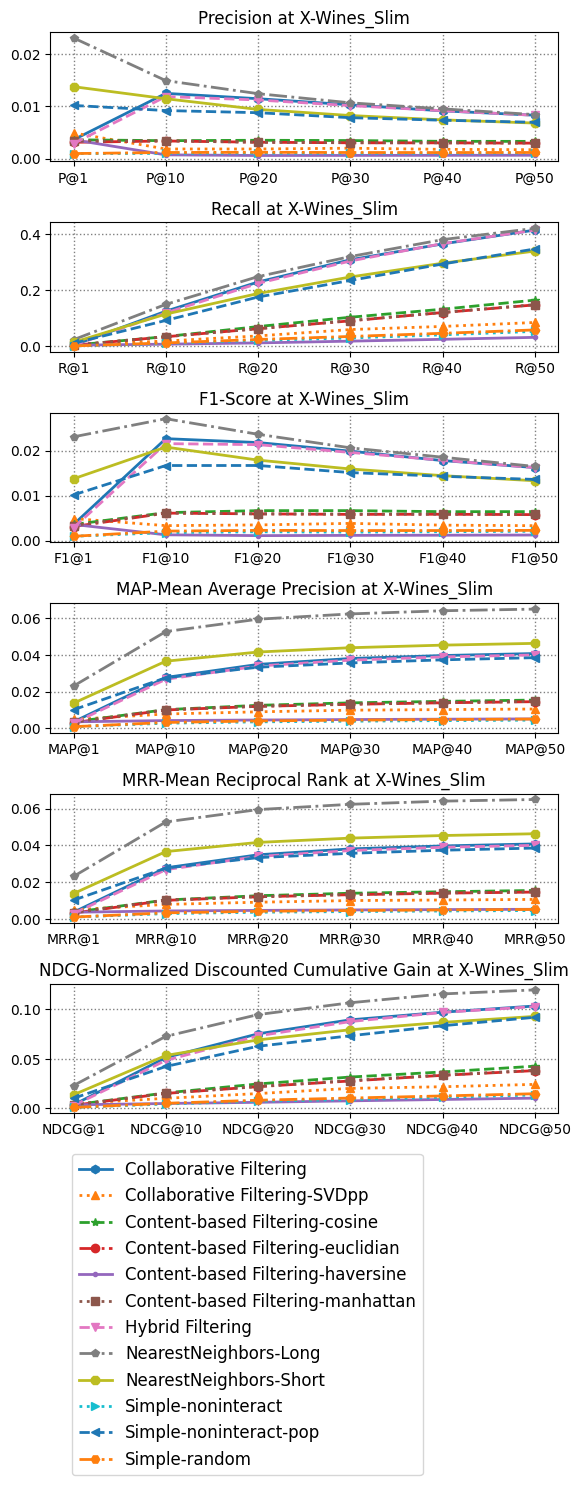

In [39]:
markers = ['h', '^', '*', 'o', '.', 's', 'v', 'p', '8', '>', '<', 'H', 'D', 'd', 'P', 'X']
labels = ['precisionLabels', 'recallLabels', 'f1ScoreLabels', 'MAPLabels', 'MRRLabels', 'nDCGLabels']
titles = ['Precision', 'Recall', 'F1-Score', 'MAP-Mean Average Precision', 'MRR-Mean Reciprocal Rank', 'NDCG-Normalized Discounted Cumulative Gain']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted', 'dashed', 'dashdot', 'solid']

def plotEvaluation(resultsDF):
    plt.figure(figsize=(6,15))
    for i in range(6):
        plt.subplot(6,1,i+1)
        for j in range(len(resultsDF)):
            plt.plot(resultsDF[eval(labels[i])].transpose()[j], label=resultsDF.Name.transpose()[j], linestyle=linestyles[j], marker=markers[j], linewidth=2)
        plt.title(titles[i]+' at '+ datasetName, fontdict={'fontsize': 12})
        plt.grid(color='gray', linestyle='dotted', linewidth=1) 
        plt.yticks(minor=False)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.15)
    plt.legend(bbox_to_anchor=(0.75,-0.25), fontsize=12)
    #plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

plotEvaluation(resultsDF)

In [40]:
res = resultsDF.transpose()
for index, row in res[1:].iterrows():
    value = 0
    for col in res.columns:
        if row[col] > value:
            value = row[col]
    for col in res.columns:
        if row[col] == value:
            res.at[index, col] = str(row[col])+' (*)'
        else:
            calc = round( (row[col]-value)*100/row[col], 3)
            res.at[index, col] = str(row[col])+' ('+str(calc)+'%)'
res

,0,1,2,3,4,5,6,7,8,9,10,11
Name,Collaborative Filtering,Collaborative Filtering-SVDpp,Content-based Filtering-cosine,Content-based Filtering-euclidian,Content-based Filtering-haversine,Content-based Filtering-manhattan,Hybrid Filtering,NearestNeighbors-Long,NearestNeighbors-Short,Simple-noninteract,Simple-noninteract-pop,Simple-random
P@1,0.003585 (-543.264%),0.004899 (-370.729%),0.003585 (-543.264%),0.003107 (-642.227%),0.003585 (-543.264%),0.003346 (-589.211%),0.002868 (-704.079%),0.023061 (*),0.013741 (-67.826%),0.000956 (-2312.238%),0.010157 (-127.045%),0.000956 (-2312.238%)
R@1,0.003585 (-543.264%),0.004899 (-370.729%),0.003585 (-543.264%),0.003107 (-642.227%),0.003585 (-543.264%),0.003346 (-589.211%),0.002868 (-704.079%),0.023061 (*),0.013741 (-67.826%),0.000956 (-2312.238%),0.010157 (-127.045%),0.000956 (-2312.238%)
F1@1,0.003585 (-543.264%),0.004899 (-370.729%),0.003585 (-543.264%),0.003107 (-642.227%),0.003585 (-543.264%),0.003346 (-589.211%),0.002868 (-704.079%),0.023061 (*),0.013741 (-67.826%),0.000956 (-2312.238%),0.010157 (-127.045%),0.000956 (-2312.238%)
MAP@1,0.003585 (-543.264%),0.004899 (-370.729%),0.003585 (-543.264%),0.003107 (-642.227%),0.003585 (-543.264%),0.003346 (-589.211%),0.002868 (-704.079%),0.023061 (*),0.013741 (-67.826%),0.000956 (-2312.238%),0.010157 (-127.045%),0.000956 (-2312.238%)
MRR@1,0.003585 (-543.264%),0.004899 (-370.729%),0.003585 (-543.264%),0.003107 (-642.227%),0.003585 (-543.264%),0.003346 (-589.211%),0.002868 (-704.079%),0.023061 (*),0.013741 (-67.826%),0.000956 (-2312.238%),0.010157 (-127.045%),0.000956 (-2312.238%)
NDCG@1,0.003585 (-543.264%),0.004899 (-370.729%),0.003585 (-543.264%),0.003107 (-642.227%),0.003585 (-543.264%),0.003346 (-589.211%),0.002868 (-704.079%),0.023061 (*),0.013741 (-67.826%),0.000956 (-2312.238%),0.010157 (-127.045%),0.000956 (-2312.238%)
P@10,0.012463 (-19.554%),0.001828 (-715.098%),0.003417 (-336.055%),0.003358 (-343.716%),0.000705 (-2013.475%),0.003382 (-340.568%),0.011853 (-25.707%),0.0149 (*),0.011435 (-30.302%),0.00098 (-1420.408%),0.009177 (-62.362%),0.001159 (-1185.591%)
R@10,0.124627 (-19.558%),0.018282 (-715.02%),0.034174 (-336.01%),0.033576 (-343.775%),0.00705 (-2013.504%),0.033815 (-340.639%),0.118533 (-25.705%),0.149002 (*),0.114351 (-30.302%),0.009798 (-1420.739%),0.091767 (-62.37%),0.01159 (-1185.608%)
F1@10,0.022659 (-19.56%),0.003324 (-715.012%),0.006213 (-336.037%),0.006105 (-343.751%),0.001282 (-2013.183%),0.006148 (-340.647%),0.021551 (-25.706%),0.027091 (*),0.020791 (-30.302%),0.001781 (-1421.112%),0.016685 (-62.367%),0.002107 (-1185.762%)


In [ ]:
res.to_csv(f"{datasetName}/resultsComparative_{datasetName}.csv", index=True)